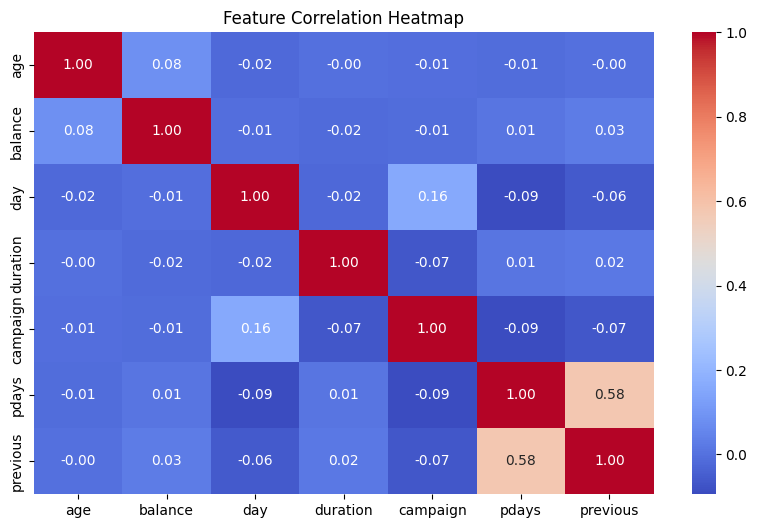

<ipython-input-1-905815dce5c2>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="y", data=data, palette="coolwarm")


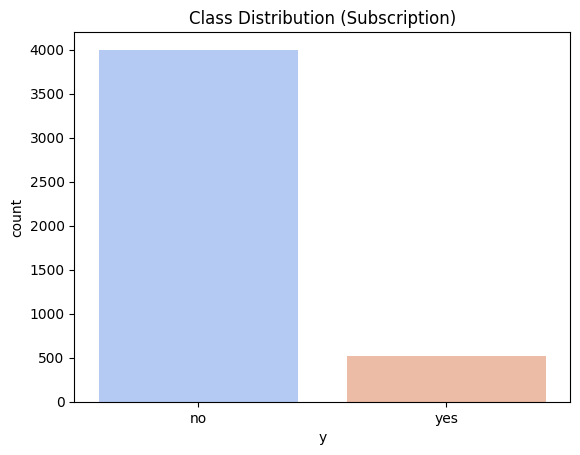

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPC Accuracy: 0.8873
GPC ROC-AUC Score: 0.9000

GPC Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94       801
           1       0.52      0.29      0.37       104

    accuracy                           0.89       905
   macro avg       0.71      0.63      0.65       905
weighted avg       0.87      0.89      0.87       905



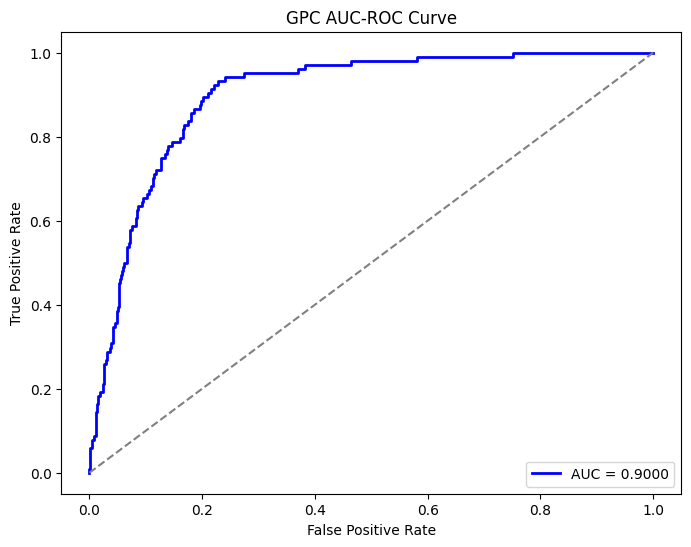

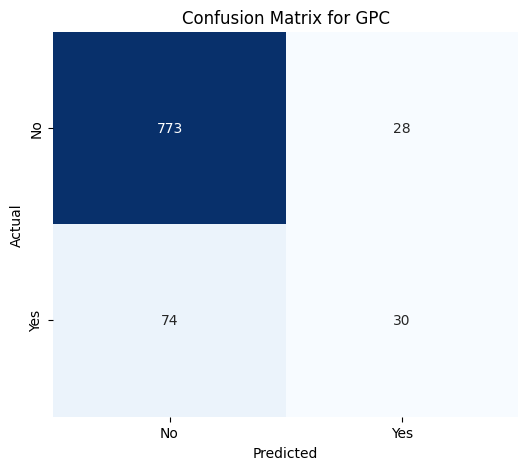

/usr/local/lib/python3.11/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR R²: 0.5427
GPR MSE: 6477751.6670


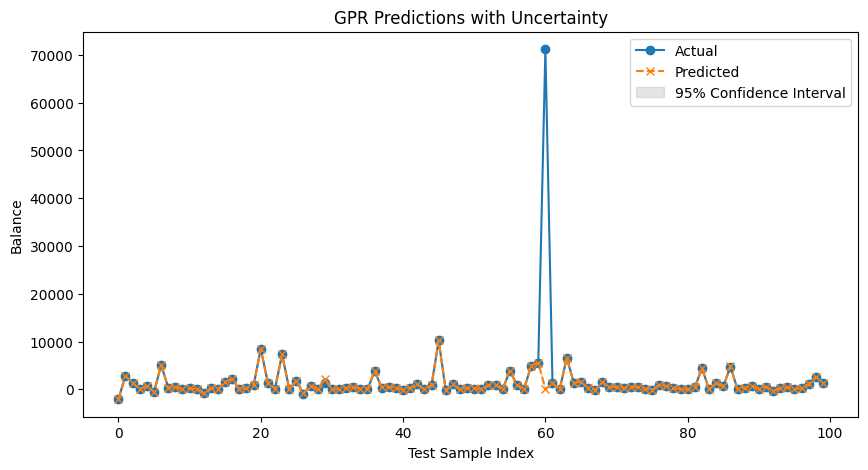

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score, r2_score, mean_squared_error, mean_absolute_error
)

# Load dataset
file_path = '/content/bank.csv'  # Update if needed
data = pd.read_csv(file_path, sep=';')

# Feature Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Class Distribution
sns.countplot(x="y", data=data, palette="coolwarm")
plt.title("Class Distribution (Subscription)")
plt.show()

# Define categorical and numerical features
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('y')
numerical_cols = data.select_dtypes(exclude=['object']).columns.tolist()

# One-hot encoding for categorical features
encoder = OneHotEncoder(drop='first')

# Standardization for numerical features
scaler = StandardScaler()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', scaler, numerical_cols),
    ('cat', encoder, categorical_cols)
])

# Encode target variable
data['y'] = data['y'].map({'yes': 1, 'no': 0})

# Split Data
X_class = data.drop('y', axis=1)
y_class = data['y']
X_reg = data.drop(['y'], axis=1)
y_reg = data['balance']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.2, random_state=42, stratify=y_class)

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

# Transform Data
X_train_class_transformed = preprocessor.fit_transform(X_train_class).toarray()
X_test_class_transformed = preprocessor.transform(X_test_class).toarray()

reg_preprocessor = ColumnTransformer([
    ('num', scaler, numerical_cols),
    ('cat', encoder, categorical_cols)
])

reg_preprocessor.fit(X_train_reg)
X_train_reg_transformed = reg_preprocessor.transform(X_train_reg).toarray()
X_test_reg_transformed = reg_preprocessor.transform(X_test_reg).toarray()

# ============================
# Gaussian Process Classification (GPC)
# ============================
base_kernel = C(1.0, (0.1, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0))
gpc = GaussianProcessClassifier(kernel=base_kernel, random_state=42)

# Grid Search for GPC
param_grid = {
    "kernel": [
        C(1.0, (0.1, 10.0)) * RBF(length_scale=0.5, length_scale_bounds=(0.1, 10.0)),
        C(1.0, (0.1, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0)),
        C(1.0, (0.1, 10.0)) * RBF(length_scale=2.0, length_scale_bounds=(0.1, 10.0))
    ]
}

grid_search = GridSearchCV(gpc, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_class_transformed, y_train_class)

# Train the best model
best_gpc = grid_search.best_estimator_
y_pred_class = best_gpc.predict(X_test_class_transformed)

# Evaluation Metrics for GPC
accuracy_gpc = accuracy_score(y_test_class, y_pred_class)
roc_auc_gpc = roc_auc_score(y_test_class, best_gpc.predict_proba(X_test_class_transformed)[:, 1])

print(f"GPC Accuracy: {accuracy_gpc:.4f}")
print(f"GPC ROC-AUC Score: {roc_auc_gpc:.4f}")
print("\nGPC Classification Report:\n", classification_report(y_test_class, y_pred_class))

# AUC-ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, best_gpc.predict_proba(X_test_class_transformed)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f'AUC = {roc_auc_gpc:.4f}')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("GPC AUC-ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for GPC
cm = confusion_matrix(y_test_class, y_pred_class)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for GPC')
plt.show()

# ============================
# Gaussian Process Regression (GPR)
# ============================
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, random_state=42)

# Train GPR
gpr.fit(X_train_reg_transformed, y_train_reg)

# Predict GPR
y_pred_reg, std_dev = gpr.predict(X_test_reg_transformed, return_std=True)

# Evaluation Metrics for GPR
r2_gpr = r2_score(y_test_reg, y_pred_reg)
mse_gpr = mean_squared_error(y_test_reg, y_pred_reg)
rmse_gpr = np.sqrt(mse_gpr)
mae_gpr = mean_absolute_error(y_test_reg, y_pred_reg)
lml_gpr = gpr.log_marginal_likelihood()

print(f"GPR R²: {r2_gpr:.4f}")
print(f"GPR MSE: {mse_gpr:.4f}")


# Visualization of GPR Predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test_reg.values[:100], label="Actual", marker='o')
plt.plot(y_pred_reg[:100], label="Predicted", marker='x', linestyle="dashed")
plt.fill_between(np.arange(100),
                 y_pred_reg[:100] - 1.96 * std_dev[:100],
                 y_pred_reg[:100] + 1.96 * std_dev[:100],
                 color='gray', alpha=0.2, label="95% Confidence Interval")
plt.title("GPR Predictions with Uncertainty")
plt.xlabel("Test Sample Index")
plt.ylabel("Balance")
plt.legend()
plt.show()
